In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import Callback

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.plotting.register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
def plot_activity(activity, df):
    ''' for making exploratory plots
        argument:
            activity: the type of activity
            df: the dataframe with the data
    '''
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12))
    plt.suptitle(activity, fontsize=20)
    for ax in axis:
        ax.legend(loc='lower right')
    plt.show()
    
def create_dataset(X, y, time_steps=1, steps=1):
    ''' Create the dataset
        arguments: 
            X: the dataset of the sensor signal
            y: the dataset of the activity labels
            time_steps: the number of timesteps in a datapoint
            steps: gap in the rolling window to modulate overlap
        returns: the rolling window dataset
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, steps):
        Xs.append(X.iloc[i: i + time_steps].values)
        ys.append(stats.mode(y.iloc[i: i + time_steps])[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def plot_history(history):
    """ Plots to track the history of the metrics
        argument:
            history: the history from training the tf model
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy [y]')
    plt.plot(hist['epoch'], hist['acc'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_acc'], label='val accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    
class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=5):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/50.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch: ' + str(self.best_epoch))
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2

In [3]:
# names of the columns
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

# read the data into a dataframe (source: https://www.cis.fordham.edu/wisdm/dataset.php)
# Fordham HAR data using smartphones (2012)
df = pd.read_csv('data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)
df.head()

# remove Upstairs and Downstairs (they are not well separated in signature)
df = df.drop(df[df['activity']=='Downstairs'].index)
df = df.drop(df[df['activity']=='Upstairs'].index)

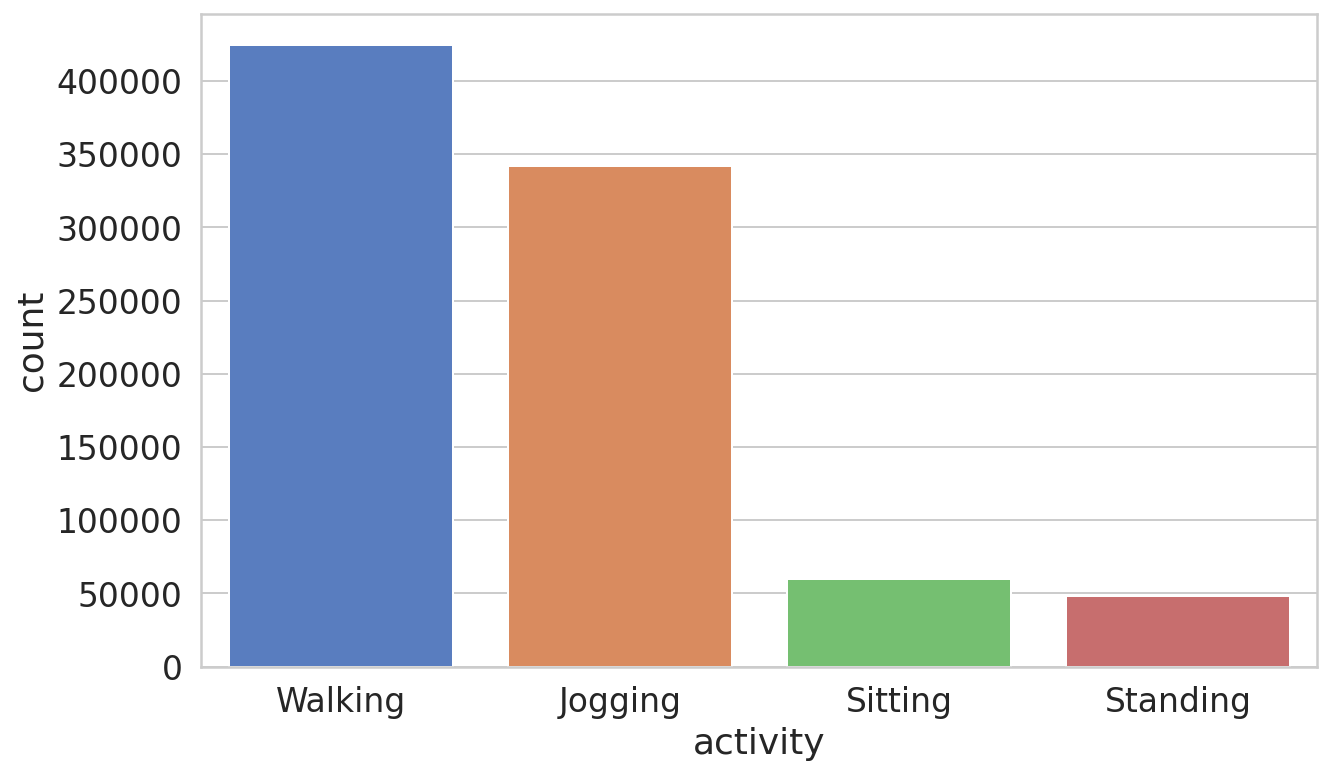

In [4]:
# explore the data
plt.figure(figsize=(10,6))
sns.countplot(x='activity', data=df, order=df.activity.value_counts().index)
plt.show()

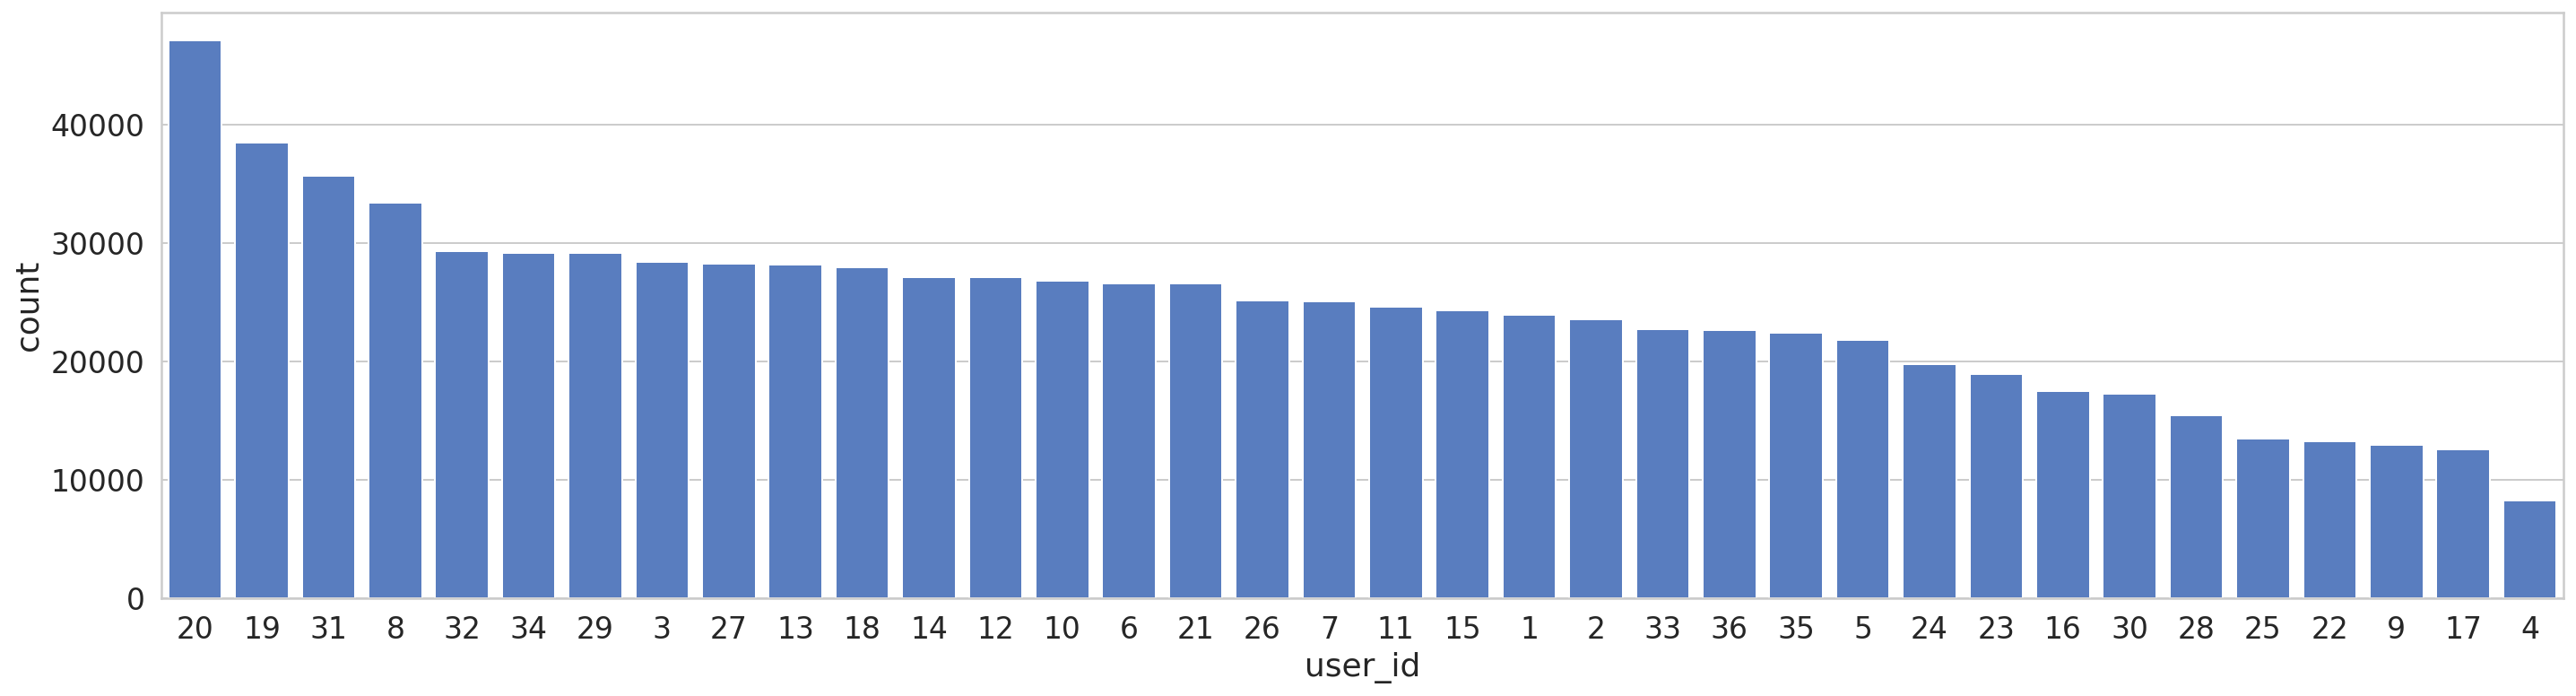

In [5]:
# datapoints from each user
plt.figure(figsize=(24,6))
sns.countplot(x='user_id', data=df, palette=[sns.color_palette()[0]], order=df.user_id.value_counts().index)
plt.show()

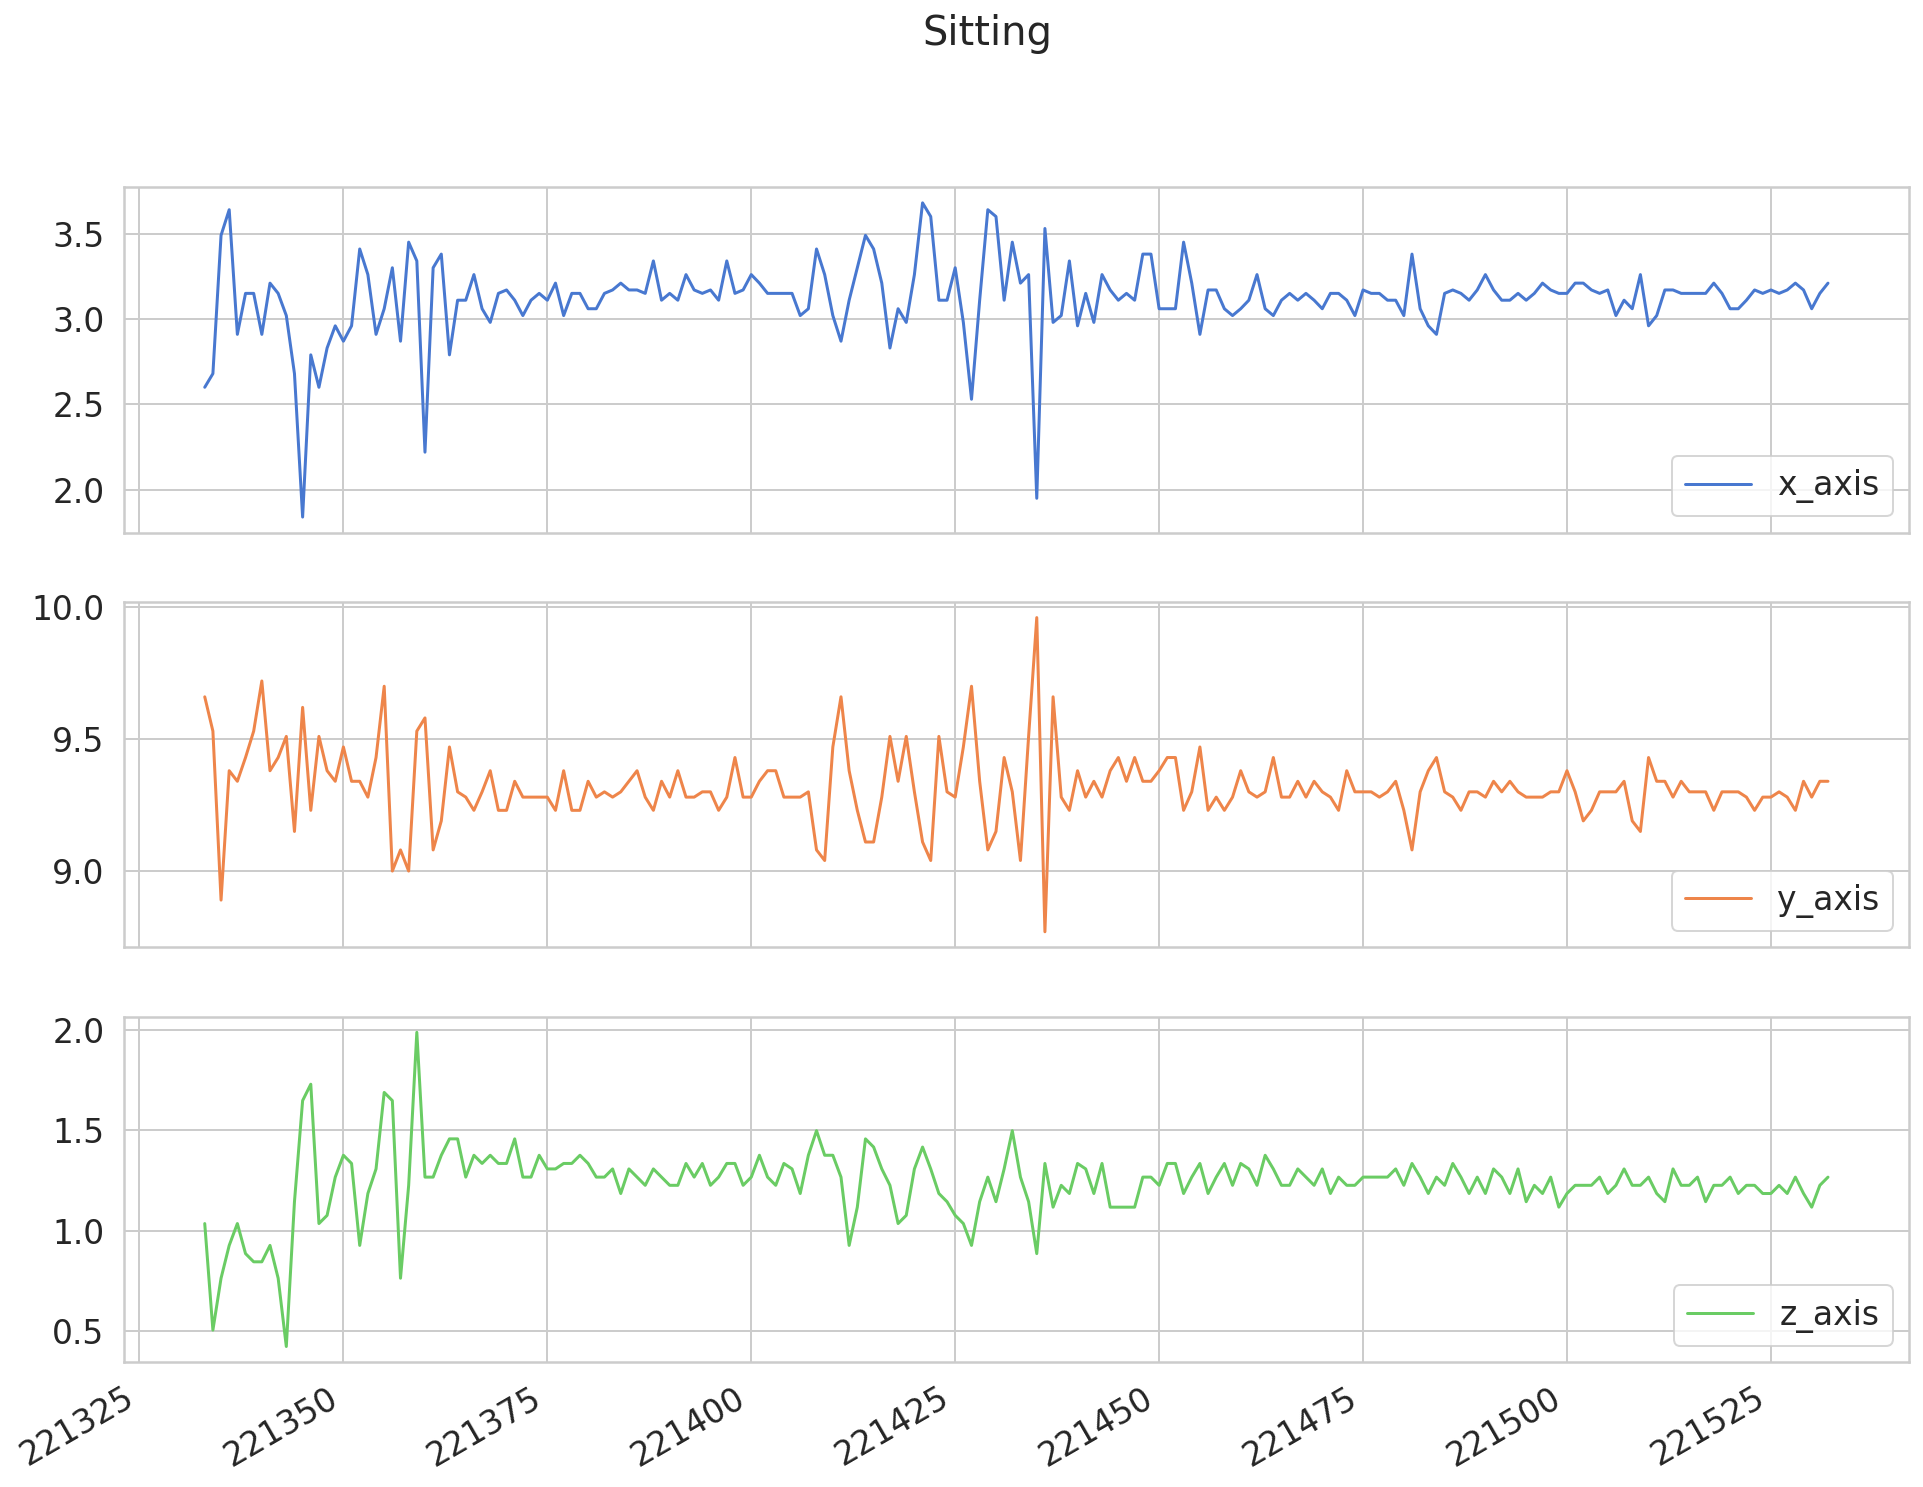

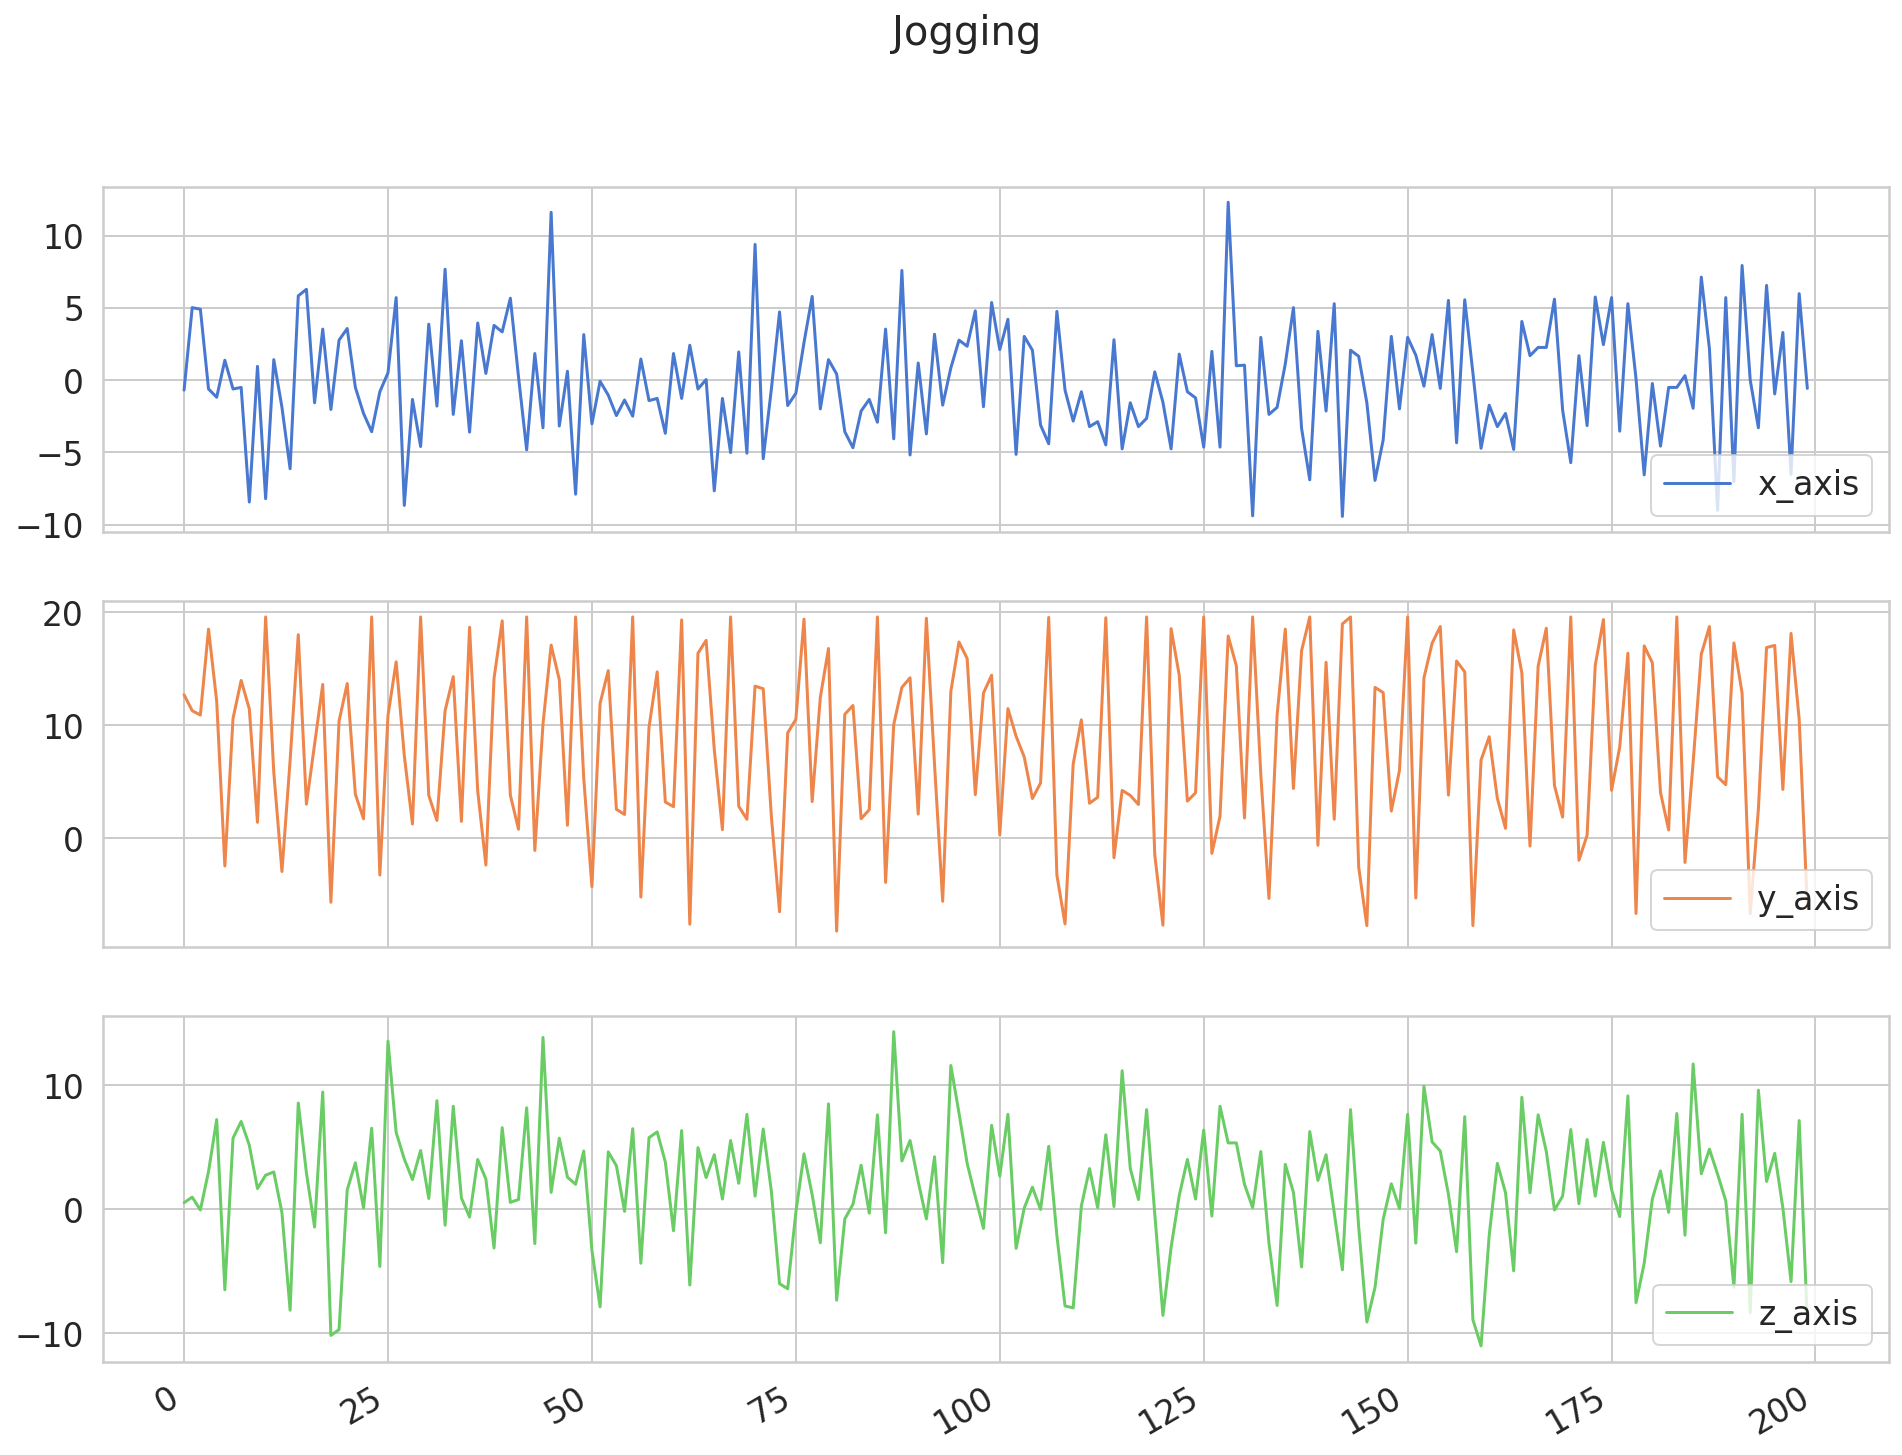

In [6]:
plot_activity('Sitting', df)
plot_activity('Jogging', df)

In [7]:
# leave out 6 users for testing (about 16% of the data)
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [8]:
# scaling the data
scale_columns = ['x_axis', 'y_axis', 'z_axis']
scaler = RobustScaler()
scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [9]:
# split into the rolling window for size TIME_STEPS with gaps of STEPS
TIME_STEPS = 200
STEPS = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    time_steps=TIME_STEPS,
    steps=STEPS
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    time_steps=TIME_STEPS,
    steps=STEPS
)

In [10]:
# one hot encoding of the categorical output labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [31]:
# Build a bidirectional GRU model
tardis = tf.keras.Sequential()
tardis.add(
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            units=32
            
        ),
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
)

tardis.add(tf.keras.layers.Dropout(rate=0.2))
tardis.add(tf.keras.layers.Dense(units=32, activation='relu'))
tardis.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))
tardis.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
tardis.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 64)                7104      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 132       
Total params: 9,316
Trainable params: 9,316
Non-trainable params: 0
_________________________________________________________________


In [32]:
# train the model
history = tardis.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
    shuffle=False,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=2)]
)

Epoch 1/25
56/56 [==============================] - 8s 136ms/step - loss: 1.3144 - acc: 0.3873 - val_loss: 1.0902 - val_acc: 0.6512
Epoch 2/25
56/56 [==============================] - 7s 130ms/step - loss: 0.9763 - acc: 0.6481 - val_loss: 0.7369 - val_acc: 0.7553
Epoch 3/25
56/56 [==============================] - 7s 127ms/step - loss: 0.7873 - acc: 0.6924 - val_loss: 0.6773 - val_acc: 0.7719
Epoch 4/25
56/56 [==============================] - 7s 128ms/step - loss: 0.6830 - acc: 0.7466 - val_loss: 0.5909 - val_acc: 0.8050
Epoch 5/25
56/56 [==============================] - 7s 130ms/step - loss: 0.5631 - acc: 0.8045 - val_loss: 0.5598 - val_acc: 0.8179
Epoch 6/25
56/56 [==============================] - 7s 129ms/step - loss: 0.4986 - acc: 0.8348 - val_loss: 0.4937 - val_acc: 0.8692
Epoch 7/25
56/56 [==============================] - 7s 129ms/step - loss: 0.4661 - acc: 0.8386 - val_loss: 0.4522 - val_acc: 0.8855
Epoch 8/25
56/56 [==============================] - 7s 131ms/step - loss: 0.

In [33]:
# test the accuracy of the model
loss, acc = tardis.evaluate(X_test, y_test, verbose=0)
print('loss: {:1.4f}, test accuracy: {:2.2f}%'.format(loss, acc*100))

loss: 0.2241, test accuracy: 95.23%


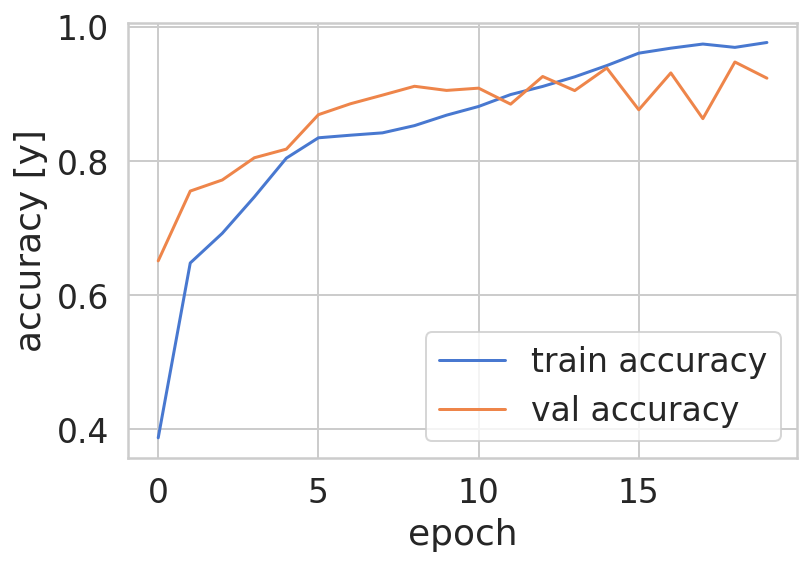

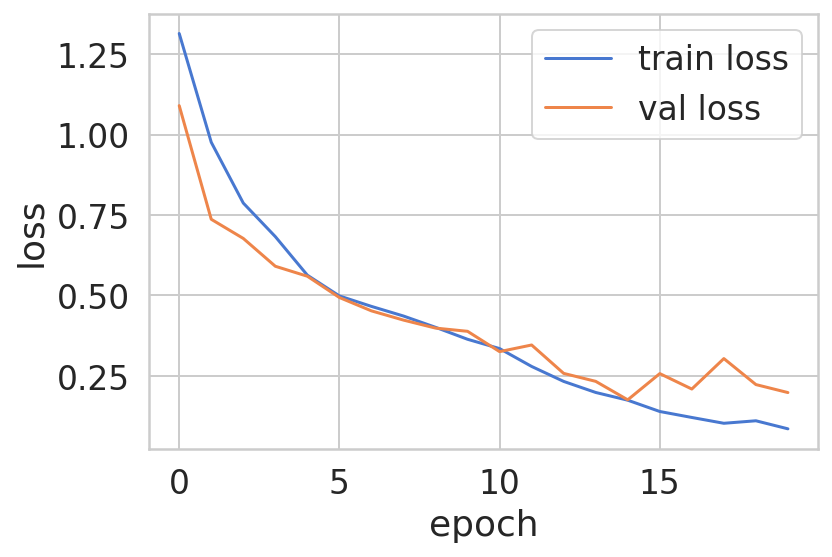

In [34]:
# plot the training history
plot_history(history)